In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy #should research
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #should research

from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential


import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
input_path = 'C:/Users/HP/Desktop/MY PROJECT/LENET/input/'
os.listdir(input_path)

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [4]:
main_dir = 'main_dir'
os.mkdir(main_dir)

train_dir = os.path.join(main_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(main_dir, 'val_dir')
os.mkdir(val_dir)

test_dir = os.path.join(main_dir, 'test_dir')
os.mkdir(test_dir)

nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

nv = os.path.join(test_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(test_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(test_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(test_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(test_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(test_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(test_dir, 'df')
os.mkdir(df)

nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)


In [5]:
df_data = pd.read_csv(input_path + 'HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True) #should research

In [7]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']

df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

In [8]:
df.shape

(5514, 7)

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [10]:
from sklearn.model_selection import KFold, StratifiedKFold
                         
skf = StratifiedKFold(n_splits = 10,random_state = 7, shuffle = True) 

In [11]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

y = df['dx']
print(df.shape)

#_, df_val = train_test_split(df, test_size = 0.17, random_state=101, stratify=y)
#should research
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.3627, random_state=1)

df_test, df_val, y_test, y_val = train_test_split(df_test, y_test, test_size=0.5, random_state=1)
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5514, 8)
(3514, 8)
(1000, 8)
(1000, 8)


In [12]:
def identify_val_rows(x):
    
    val_list = list(df_val['image_id'])
    test_list = list(df_test['image_id'])
    
    if str(x) in val_list or str(x) in test_list:
        return 'val'
    else:
        return 'train'
    
    
df_data['train_or_val'] = df_data['image_id']

df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

df_train = df_data[df_data['train_or_val'] == 'train']

In [13]:
df_train

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,has_duplicates,train
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,has_duplicates,train
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,has_duplicates,train
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,has_duplicates,train


In [14]:
df_val

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
905,HAM_0005845,ISIC_0025851,bkl,consensus,80.0,female,face,no_duplicates
3857,HAM_0005397,ISIC_0028105,nv,follow_up,35.0,male,lower extremity,no_duplicates
2213,HAM_0006744,ISIC_0031561,mel,histo,55.0,male,back,no_duplicates
3989,HAM_0001909,ISIC_0025481,nv,follow_up,55.0,male,upper extremity,no_duplicates
4028,HAM_0000010,ISIC_0027730,nv,follow_up,70.0,female,back,no_duplicates
...,...,...,...,...,...,...,...,...
6034,HAM_0006589,ISIC_0031187,nv,follow_up,40.0,male,trunk,no_duplicates
3861,HAM_0007285,ISIC_0026718,nv,follow_up,55.0,female,genital,no_duplicates
8105,HAM_0004014,ISIC_0029809,nv,histo,45.0,male,chest,no_duplicates
6426,HAM_0005716,ISIC_0031841,nv,follow_up,50.0,male,back,no_duplicates


In [15]:
df_test

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
5637,HAM_0002248,ISIC_0029011,nv,follow_up,40.0,female,trunk,no_duplicates
8226,HAM_0001212,ISIC_0024846,nv,histo,40.0,female,back,no_duplicates
9403,HAM_0003362,ISIC_0033313,nv,consensus,45.0,female,unknown,no_duplicates
5619,HAM_0001395,ISIC_0031818,nv,follow_up,50.0,female,foot,no_duplicates
1947,HAM_0005600,ISIC_0025520,mel,histo,65.0,male,back,no_duplicates
...,...,...,...,...,...,...,...,...
999,HAM_0004078,ISIC_0026566,bkl,consensus,70.0,female,trunk,no_duplicates
635,HAM_0001486,ISIC_0029384,bkl,histo,40.0,male,face,no_duplicates
2957,HAM_0000807,ISIC_0032164,bcc,histo,65.0,female,chest,no_duplicates
4710,HAM_0000334,ISIC_0026860,nv,follow_up,35.0,female,abdomen,no_duplicates


In [16]:
df_data.set_index('image_id', inplace=True)

folder_1 = os.listdir(input_path + 'ham10000_images_part_1')
folder_2 = os.listdir(input_path + 'ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])


for image in train_list:
    
    file_name = image + '.jpg'
    label = df_data.loc[image, 'dx']
    
    if file_name in folder_1:
        
        src = os.path.join(input_path + 'ham10000_images_part_1', file_name)
        dst = os.path.join(train_dir, label, file_name)
        
        shutil.copy(src, dst)
    
    if file_name in folder_2:
        
        src = os.path.join(input_path + 'ham10000_images_part_2', file_name)
        dst = os.path.join(train_dir, label, file_name)
        
        shutil.copy(src, dst)
        

for image in val_list:
    
    file_name = image + '.jpg'
    label = df_data.loc[image, 'dx']
    
    if file_name in folder_1:
        
        src = os.path.join(input_path + 'ham10000_images_part_1', file_name)
        dst = os.path.join(val_dir, label, file_name)
        
        shutil.copy(src, dst)
    
    if file_name in folder_2:
        
        src = os.path.join(input_path + 'ham10000_images_part_2', file_name)
        dst = os.path.join(val_dir, label, file_name)
        shutil.copy(src, dst)
        
        
for image in test_list:
    
    file_name = image + '.jpg'
    label = df_data.loc[image, 'dx']
    
    if file_name in folder_1:
        
        src = os.path.join(input_path + 'ham10000_images_part_1', file_name)
        dst = os.path.join(test_dir, label, file_name)
        
        shutil.copy(src, dst)
    
    if file_name in folder_2:
        
        src = os.path.join(input_path + 'ham10000_images_part_2', file_name)
        dst = os.path.join(test_dir, label, file_name)
        
        shutil.copy(src, dst)

**Data Augumentataion**

In [17]:
class_list = ['mel', 'bkl','bcc','akiec','vasc','df']

for clas in class_list:
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)
    
    img_class = clas
    
    img_list = os.listdir(train_dir +"/"+ img_class)
    
    for fname in img_list:
        
        src = os.path.join(train_dir +"/" + img_class,fname)
#         dst = os.path.join(img_dir,fname)
        dst = img_dir
        
        shutil.copy(src, dst)
        
    path = aug_dir
    save_path = train_dir +"/" + img_class
    
    datagen = ImageDataGenerator(rotation_range=180,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')
    batch_size = 50
    
    aug_datagen = datagen.flow_from_directory(path, save_to_dir = save_path, save_format='jpg',target_size=(224,224),batch_size=batch_size)
    
    num_aug_imgs_wanted = 6000
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_imgs_wanted - num_files)/batch_size))
    
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen) #should research
        
    shutil.rmtree('aug_dir')

Found 1026 images belonging to 1 classes.
Found 942 images belonging to 1 classes.
Found 454 images belonging to 1 classes.
Found 284 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 103 images belonging to 1 classes.


In [18]:
num_train_samples = 8000
num_val_samples = 1000
num_test_samples = 1000
train_batch_size = 10
val_batch_size = 10
test_batch_size = 10
image_size = 28

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [19]:
train_dir

'main_dir\\train_dir'

In [20]:
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_dir,target_size = (image_size, image_size), batch_size=train_batch_size)

val_batches = datagen.flow_from_directory(val_dir,target_size=(image_size, image_size), batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=1,shuffle=False)


Found 37266 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.


In [21]:
model = Sequential()
model.add(Convolution2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 3)))
# model.summary()
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [23]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [24]:
idg = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

In [27]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'duplicates'],
      dtype='object')

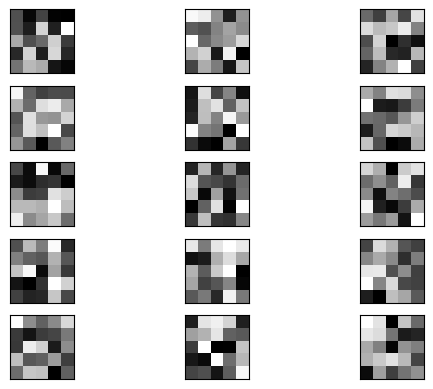

In [28]:
from matplotlib import pyplot
from matplotlib import pyplot as plt
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()


In [29]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

hist = model.fit(train_batches, steps_per_epoch=train_steps, epochs=20, validation_data= val_batches, validation_steps=val_steps)



Epoch 1/20


800/800 [==============================] - 89s 107ms/step - loss: 1.5468 - accuracy: 0.3869 - val_loss: 1.4128 - val_accuracy: 0.5100
Epoch 2/20
800/800 [==============================] - 84s 105ms/step - loss: 1.3626 - accuracy: 0.4690 - val_loss: 0.7878 - val_accuracy: 0.7330
Epoch 3/20
800/800 [==============================] - 85s 106ms/step - loss: 1.2660 - accuracy: 0.5030 - val_loss: 1.0545 - val_accuracy: 0.6560
Epoch 4/20
800/800 [==============================] - 86s 108ms/step - loss: 1.2240 - accuracy: 0.5264 - val_loss: 0.9446 - val_accuracy: 0.6610
Epoch 5/20
800/800 [==============================] - 80s 100ms/step - loss: 1.1810 - accuracy: 0.5371 - val_loss: 1.1166 - val_accuracy: 0.6050
Epoch 6/20
800/800 [==============================] - 82s 102ms/step - loss: 1.1346 - accuracy: 0.5605 - val_loss: 0.9140 - val_accuracy: 0.6820
Epoch 7/20
800/800 [==============================] - 81s 101ms/step - loss: 1.1335 - accuracy: 0.5631 - val_loss: 0.7988 - val

In [30]:
model.save("model.h5")

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


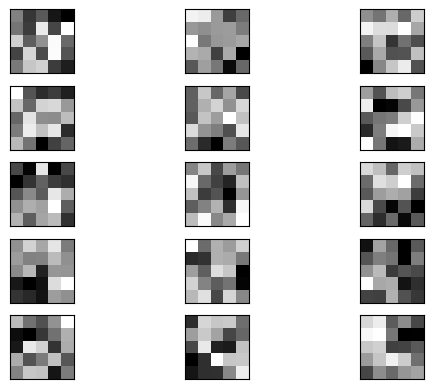

In [31]:
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()


In [32]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from numpy import expand_dims

In [33]:
predictions = model.predict(test_batches, steps=1000, verbose=1)

1000/1000 [==============================] - 31s 31ms/step


In [34]:
print(predictions)

[[2.51784325e-01 3.64047498e-01 5.34739271e-02 ... 2.02095937e-02
  1.92489605e-02 1.09071133e-03]
 [1.07709162e-01 5.50557196e-01 2.51302749e-01 ... 9.77243297e-03
  2.55064927e-02 1.72783213e-04]
 [1.05037443e-01 1.65216103e-01 2.77019858e-01 ... 6.76966086e-02
  2.78981745e-01 1.15497876e-03]
 ...
 [3.51921850e-32 1.04211039e-16 6.95315946e-18 ... 6.61020277e-16
  1.21875018e-16 1.00000000e+00]
 [3.56659181e-02 3.14379334e-01 1.13588974e-01 ... 5.74943200e-02
  1.42729297e-01 2.73416668e-01]
 [1.63643267e-06 1.11820512e-01 2.54109851e-04 ... 1.33635011e-04
  5.31234946e-05 8.87723982e-01]]


In [35]:
test_labels = test_batches.classes

In [36]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [37]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_19688\1241010557.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


1000/1000 [==============================] - 32s 32ms/step - loss: 0.5856 - accuracy: 0.8090


In [38]:
acc

0.8090000152587891

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('conf.png')

In [40]:
confusion_mat = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [41]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  6   6   4   0   0   1   0]
 [  4  29   2   1   0   1   0]
 [  5  12  33   2   6  23   0]
 [  0   1   0   1   0   1   0]
 [  4   2   9   0  13  10   1]
 [  6  14  30  22  18 717   2]
 [  0   4   0   0   0   0  10]]


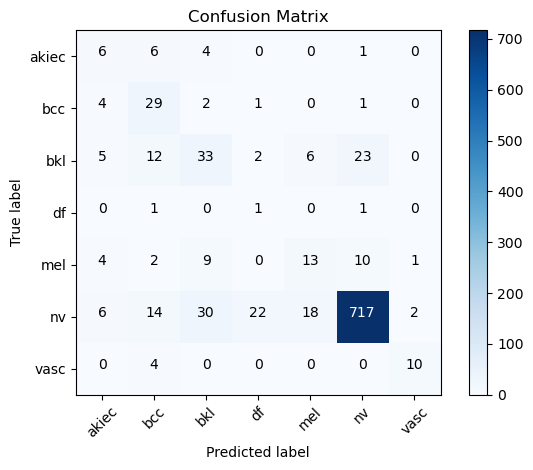

In [42]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(confusion_mat, cm_plot_labels, title='Confusion Matrix')